In [1]:
import sys
import torch

print("Python version:")
print(sys.version)

print("\nPyTorch version:")
print(torch.__version__)

Python version:
3.12.3 | packaged by Anaconda, Inc. | (main, May  6 2024, 14:46:42) [Clang 14.0.6 ]

PyTorch version:
2.3.0


In [2]:
import pandas as pd
import numpy as np

df_train = pd.read_csv('./neural_collaborative_filtering/data/ml-1m.train.rating', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
df_train.drop(columns='timestamp', inplace=True)

all_items = set(range(3706))
negative_samples = {uid: [] for uid in df_train['user_id'].unique()}
df_train['rating'] = 1

for user_id in negative_samples:
    pos_items = set(df_train[df_train['user_id'] == user_id]['item_id'].unique())
    neg_items = list(all_items - pos_items)
    chosen_negatives = np.random.choice(neg_items, 80, replace=False)
    negative_samples[user_id].extend(chosen_negatives)

neg_data_list = [[user_id, item, 0] for user_id, items in negative_samples.items() for item in items]
df_negatives = pd.DataFrame(neg_data_list, columns=['user_id', 'item_id', 'rating'])

df_final = pd.concat([df_train, df_negatives], ignore_index=True)
df_final.to_csv('./neural_collaborative_filtering/data/ml-1m.train.rating.final', sep='\t', header=False, index=False)

df_test = pd.read_csv('./neural_collaborative_filtering/data/ml-1m.test.rating', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
df_test.drop(columns='timestamp', inplace=True)
df_test['rating'] = 1
df_test.to_csv('./neural_collaborative_filtering/data/ml-1m.test.rating.final', sep='\t', header=False, index=False)

In [3]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset

class RatingsDataset(Dataset):
    """Dataset for loading user-item ratings."""
    def __init__(self, ratings_file):
        self.user_item_ratings = pd.read_csv(ratings_file, sep='\t', names=['user_id', 'item_id', 'rating'])
    
    def __len__(self):
        return len(self.user_item_ratings)

    def __getitem__(self, idx):
        row = self.user_item_ratings.iloc[idx]
        user_id = torch.tensor(row['user_id'], dtype=torch.int64)
        item_id = torch.tensor(row['item_id'], dtype=torch.int64)
        rating = torch.tensor(row['rating'], dtype=torch.float32)
        return user_id, item_id, rating

ratings_dataset_train = RatingsDataset('./neural_collaborative_filtering/data/ml-1m.train.rating.final')
ratings_dataset_test = RatingsDataset('./neural_collaborative_filtering/data/ml-1m.test.rating.final')

ratings_loader_train = DataLoader(ratings_dataset_train, batch_size=256, shuffle=True)
ratings_loader_test = DataLoader(ratings_dataset_test, batch_size=256, shuffle=True)

class NegativeDataset(Dataset):
    """Dataset for loading negative samples for each user-item pair."""
    def __init__(self, negative_file):
        self.negatives = self._load_negative(negative_file)

    def _load_negative(self, negative_file):
        negatives = {}
        with open(negative_file, 'r') as file:
            for line in file:
                line = line.strip().split('\t')
                user, item = eval(line[0])
                negatives[(user, item)] = list(map(int, line[1:]))
        return negatives

    def __len__(self):
        return len(self.negatives)

    def __getitem__(self, idx):
        user_item = list(self.negatives.keys())[idx]
        user_id = torch.tensor(user_item[0], dtype=torch.int64)
        item_id = torch.tensor(user_item[1], dtype=torch.int64)
        negative_ids = torch.tensor(self.negatives[user_item], dtype=torch.int64)
        return user_id, item_id, negative_ids

negative_dataset = NegativeDataset('./neural_collaborative_filtering/data/ml-1m.test.negative')
negative_loader = DataLoader(negative_dataset, batch_size=256, shuffle=False)

print(len(negative_dataset))
print(negative_dataset.__getitem__(0))


6040
(tensor(0), tensor(25), tensor([1064,  174, 2791, 3373,  269, 2678, 1902, 3641, 1216,  915, 3672, 2803,
        2344,  986, 3217, 2824, 2598,  464, 2340, 1952, 1855, 1353, 1547, 3487,
        3293, 1541, 2414, 2728,  340, 1421, 1963, 2545,  972,  487, 3463, 2727,
        1135, 3135,  128,  175, 2423, 1974, 2515, 3278, 3079, 1527, 2182, 1018,
        2800, 1830, 1539,  617,  247, 3448, 1699, 1420, 2487,  198,  811, 1010,
        1423, 2840, 1770,  881, 1913, 1803, 1734, 3326, 1617,  224, 3352, 1869,
        1182, 1331,  336, 2517, 1721, 3512, 3656,  273, 1026, 1991, 2190,  998,
        3386, 3369,  185, 2822,  864, 2854, 3067,   58, 2551, 2333, 2688, 3703,
        1300, 1924, 3118]))


In [4]:
num_users = ratings_dataset_train.user_item_ratings['user_id'].nunique()
print(num_users)
num_items = ratings_dataset_train.user_item_ratings['item_id'].nunique()
print(num_items)
max_item_id = ratings_dataset_train.user_item_ratings['item_id'].max()
print(max_item_id)
min_item_id = ratings_dataset_train.user_item_ratings['item_id'].min()
print(min_item_id)

6040
3706
3705
0


In [5]:
import torch
import torch.nn as nn

def init_weights(m):
    if isinstance(m, nn.Embedding):
        torch.nn.init.normal_(m.weight.data, mean=0.0, std=0.01)
    elif isinstance(m, nn.Linear):
        torch.nn.init.normal_(m.weight.data, mean=0.0, std=0.01)
        if m.bias is not None:
            torch.nn.init.constant_(m.bias.data, 0)

class GMF(nn.Module):
    def __init__(self, num_users, num_items, num_factors):
        super(GMF, self).__init__()
        self.user_emb = nn.Embedding(num_users, num_factors)
        self.item_emb = nn.Embedding(num_items, num_factors)
        self.apply(init_weights)

    def forward(self, user_ids, item_ids):
        user_embedding = self.user_emb(user_ids)
        item_embedding = self.item_emb(item_ids)
        output = (user_embedding * item_embedding).sum(1)
        return output.sigmoid()

class MLP(nn.Module):
    def __init__(self, num_users, num_items, layers):
        super(MLP, self).__init__()
        self.user_emb = nn.Embedding(num_users, layers[0] // 2 if layers else 8)
        self.item_emb = nn.Embedding(num_items, layers[0] // 2 if layers else 8)
        self.fc_layers = nn.ModuleList()
        for idx in range(1, len(layers)):
            self.fc_layers.append(nn.Linear(layers[idx - 1], layers[idx]))
        self.output_layer = nn.Linear(layers[-1] if layers else 16, 1)

    def forward(self, user_ids, item_ids):
        user_embedding = self.user_emb(user_ids)
        item_embedding = self.item_emb(item_ids)
        vector = torch.cat([user_embedding, item_embedding], dim=-1)
        for layer in self.fc_layers:
            vector = torch.relu(layer(vector))
        output = self.output_layer(vector)
        return output.sigmoid()

def create_mlp_model(num_users, num_items, num_factors, num_hidden_layers):
    layers = [num_factors] * num_hidden_layers if num_hidden_layers > 0 else []
    return MLP(num_users, num_items, layers)

class NeuMF(nn.Module):
    def __init__(self, num_users, num_items, num_factors, mlp_layers):
        super(NeuMF, self).__init__()
        self.gmf = GMF(num_users, num_items, num_factors)
        self.mlp = create_mlp_model(num_users, num_items, num_factors, 4)
        self.output_layer = nn.Linear(2, 1)

    def forward(self, user_ids, item_ids):
        gmf_output = self.gmf(user_ids, item_ids).unsqueeze(1)
        mlp_output = self.mlp(user_ids, item_ids)
        concatenated_output = torch.cat((gmf_output, mlp_output), dim=-1)
        output = self.output_layer(concatenated_output)
        return output.sigmoid()

In [6]:
def train(model, train_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for user_ids, item_ids, ratings in train_loader:
        optimizer.zero_grad()
        outputs = model(user_ids, item_ids)
        loss = criterion(outputs.squeeze(), ratings.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)


In [7]:
def evaluate(model, test_loader, negative_loader, top_k=10):
    model.eval()
    HR_list = []
    NDCG_list = []

    for (user_ids, pos_item_ids, _), (neg_user_ids, _, neg_item_ids) in zip(test_loader, negative_loader):
        items = torch.cat([pos_item_ids.unsqueeze(1), neg_item_ids], dim=1)
        user_ids = user_ids.unsqueeze(1).expand(-1, items.size(1))

        user_ids = user_ids.reshape(-1)
        item_ids = items.reshape(-1)
        predictions = model(user_ids, item_ids).squeeze()
        predictions = predictions.reshape(-1, 100)
        _, indices = torch.topk(predictions, k=top_k, dim=1)
        recommended_items = items.gather(1, indices)

        HR = (recommended_items == pos_item_ids.unsqueeze(1)).any(dim=1).float()
        HR_list.append(HR.mean().item())

        relevant = (recommended_items == pos_item_ids.unsqueeze(1))
        rank = relevant.nonzero(as_tuple=True)[1]
        NDCG = (1 / torch.log2(rank.float() + 2)).mean().item()
        NDCG_list.append(NDCG)

    mean_HR = np.mean(HR_list)
    mean_NDCG = np.mean(NDCG_list)
    
    return mean_HR, mean_NDCG


In [8]:
from torch.optim import Adam

num_factors = 8  # Number of latent factors for GMF
mlp_layers = [64, 32, 16, 8]  # Layer configuration for MLP

models = {
    'GMF': GMF(num_users, num_items, num_factors),
    'MLP-0': create_mlp_model(num_users, num_items, num_factors, 0),
    'MLP-1': create_mlp_model(num_users, num_items, num_factors, 1),
    'MLP-2': create_mlp_model(num_users, num_items, num_factors, 2),
    'MLP-3': create_mlp_model(num_users, num_items, num_factors, 3),
    'MLP-4': create_mlp_model(num_users, num_items, num_factors, 4),
    'NeuMF': NeuMF(num_users, num_items, num_factors, mlp_layers)
}

epochs = 200
results = {name: {'train_loss': [], 'HR@10': [], 'NDCG@10': []} for name in models}

# Training loop
for name, model in models.items():
    print(f"Training {name}")
    model = model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
    optimizer = Adam(model.parameters(), lr=0.001)
    criterion = nn.BCEWithLogitsLoss()

    for epoch in range(epochs):
        train_loss = train(model, ratings_loader_train, optimizer, criterion)
        hr, ndcg = evaluate(model, ratings_loader_test, negative_loader)

        # Store metrics
        results[name]['train_loss'].append(train_loss)
        results[name]['HR@10'].append(hr)
        results[name]['NDCG@10'].append(ndcg)

        print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, HR@10: {hr:.4f}, NDCG@10: {ndcg:.4f}')


Training GMF
Epoch 1/200, Train Loss: 0.5853, HR@10: 0.4324, NDCG@10: 0.5630
Epoch 2/200, Train Loss: 0.5527, HR@10: 0.4632, NDCG@10: 0.5645
Epoch 3/200, Train Loss: 0.5436, HR@10: 0.4727, NDCG@10: 0.5661
Epoch 4/200, Train Loss: 0.5341, HR@10: 0.4675, NDCG@10: 0.5750
Epoch 5/200, Train Loss: 0.5238, HR@10: 0.4666, NDCG@10: 0.5848
Epoch 6/200, Train Loss: 0.5178, HR@10: 0.4788, NDCG@10: 0.5818
Epoch 7/200, Train Loss: 0.5148, HR@10: 0.4804, NDCG@10: 0.5913
Epoch 8/200, Train Loss: 0.5127, HR@10: 0.4801, NDCG@10: 0.5974
Epoch 9/200, Train Loss: 0.5106, HR@10: 0.4886, NDCG@10: 0.6005
Epoch 10/200, Train Loss: 0.5086, HR@10: 0.4902, NDCG@10: 0.6071
Epoch 11/200, Train Loss: 0.5067, HR@10: 0.4931, NDCG@10: 0.6084
Epoch 12/200, Train Loss: 0.5049, HR@10: 0.5067, NDCG@10: 0.6069
Epoch 13/200, Train Loss: 0.5034, HR@10: 0.5062, NDCG@10: 0.6127
Epoch 14/200, Train Loss: 0.5021, HR@10: 0.5141, NDCG@10: 0.6123
Epoch 15/200, Train Loss: 0.5009, HR@10: 0.5158, NDCG@10: 0.6134
Epoch 16/200, Train L

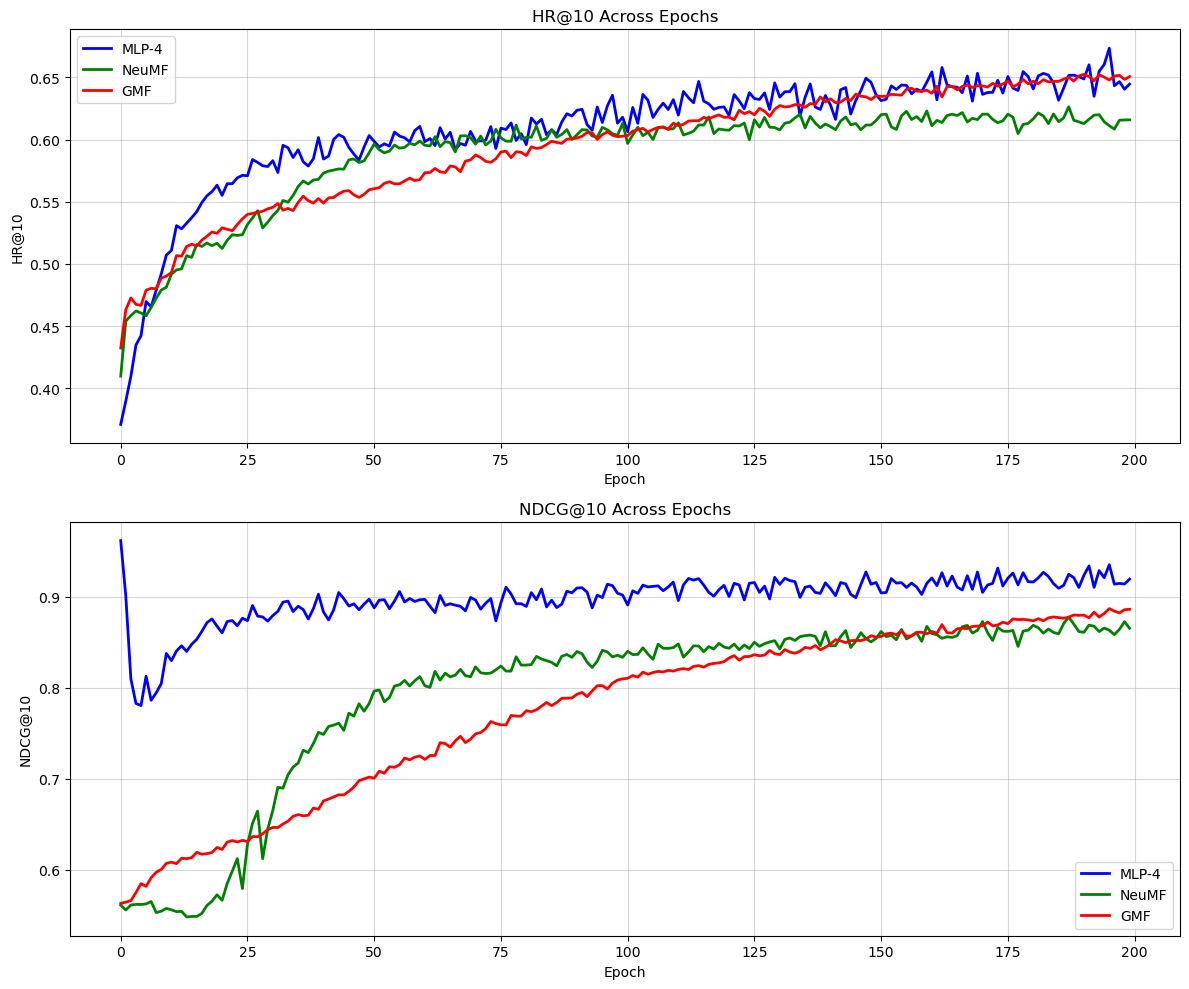

In [12]:
import matplotlib.pyplot as plt

# Set up the figure and axes
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Titles for subplots
titles = ['HR@10 Across Epochs', 'NDCG@10 Across Epochs']

# Keys to plot
keys_to_plot = ['MLP-4', 'NeuMF', 'GMF']

# Colors for different models
colors = {'MLP-4': 'blue', 'NeuMF': 'green', 'GMF': 'red'}

# Metric keys
metric_keys = ['HR@10', 'NDCG@10']

# Iterate over the metrics to create subplots
for i, metric_key in enumerate(metric_keys):
    for model_key in keys_to_plot:
        axes[i].plot(results[model_key][metric_key], label=model_key, color=colors[model_key], linewidth=2)
    axes[i].set_title(titles[i])
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel(metric_key)
    axes[i].legend()
    axes[i].grid(True, alpha=0.5)

# Adjust layout
plt.tight_layout()
plt.savefig('metrics.png')
plt.show()
